# Práctica 3 Regresión Lineal

De cara a realizar un modelo de Machine Learning, es importante seleccionar las herramientas técnicas y conocer sus ventajas y desventajas a la hora de la implementación. Tras haber utilizado en prácticas anteriores la librería scikit-learn, hoy enetenderemos como trabajar de una forma completamente similar con la librería statsmodels.

La librería **statsmodel** en Python es una herramienta poderosa para realizar análisis estadísticos y estimar modelos econométricos. Ofrece una amplia gama de funcionalidades para realizar regresiones lineales y no lineales, análisis de series temporales, pruebas de hipótesis estadísticas y más. Con statsmodels, los usuarios pueden realizar ajustes detallados de modelos estadísticos y explorar la relación entre variables, así como realizar diagnósticos sobre la validez de los modelos. Algunas características notables de statsmodels incluyen su capacidad para generar resultados detallados de los modelos ajustados, proporcionando estadísticas y diagnósticos útiles. También es ampliamente utilizado en el ámbito académico y profesional para llevar a cabo análisis estadísticos rigurosos. En resumen, statsmodels es una biblioteca esencial para aquellos que trabajan en análisis estadísticos y modelado econométrico en Python.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Se dispone de información sobre la esperanza de vida media de los habitantes de 50 ciudades, junto con información sociodemográfica de cada una de ellas. En concreto, se conocen las siguientes variables:

**habitantes**: Número de habitantes del área.

**ingresos**: Ingresos medios mensuales de los habitantes del área.

**analfabetismo**: Porcentaje de personas analfabetas (sin estudios básicos)

**asesinatos**: Tasa de asesinatos por cada 100000 habitantes

**univesitarios**: Porcentaje de universitarios en el área

**heladas**: Número de días al año con heladas en el área

**area**: Tamaño en hectáreas del área

**densidad_pobl**: Número de habitantes por hectárea

Nuestro objetivo a lo largo la práctica será predecir la esperanza de vida a partir de la información dada en nuestra BBDD. Antes de nada, analizamos los datos con las sentencias que ya conocemos de otras prácticas

In [2]:
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/'
    'Estadistica-machine-learning-python/master/data/state_x77.csv'
)
datos = pd.read_csv(url, sep=',')
datos.head(3)

,habitantes,ingresos,analfabetismo,esp_vida,asesinatos,universitarios,heladas,area,densidad_pobl
0,3615,3624,2.1,69.05,15.1,41.3,20,50708,71.290526
1,365,6315,1.5,69.31,11.3,66.7,152,566432,0.644384
2,2212,4530,1.8,70.55,7.8,58.1,15,113417,19.503249


In [3]:
datos.describe()

,habitantes,ingresos,analfabetismo,esp_vida,asesinatos,universitarios,heladas,area,densidad_pobl
count,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000
mean,4246.420000,4435.800000,1.170000,70.878600,7.37800,53.108000,104.460000,70735.880000,149.224473
std,4464.491433,614.469939,0.609533,1.342394,3.69154,8.076998,51.980848,85327.299622,221.006340
min,365.000000,3098.000000,0.500000,67.960000,1.40000,37.800000,0.000000,1049.000000,0.644384
25%,1079.500000,3992.750000,0.625000,70.117500,4.35000,48.050000,66.250000,36985.250000,25.335165
50%,2838.500000,4519.000000,0.950000,70.675000,6.85000,53.250000,114.500000,54277.000000,73.015433
75%,4968.500000,4813.500000,1.575000,71.892500,10.67500,59.150000,139.750000,81162.500000,144.282783
max,21198.000000,6315.000000,2.800000,73.600000,15.10000,67.300000,188.000000,566432.000000,975.003324


In [4]:
datos.shape

(50, 9)

In [5]:
datos.dtypes

,0
habitantes,int64
ingresos,int64
analfabetismo,float64
esp_vida,float64
asesinatos,float64
universitarios,float64
heladas,int64
area,int64
densidad_pobl,float64


In [6]:
datos.isna().sum()

,0
habitantes,0
ingresos,0
analfabetismo,0
esp_vida,0
asesinatos,0
universitarios,0
heladas,0
area,0
densidad_pobl,0


Antes de nada dividimos nuestra base de datos en conjunto de entrenamiento y conjunto de test. Separamos el X (conjunto de variables predictoras) del y (variable a predecir). Utilizamos la función tran_test_split de la librería scikit-learn para separar los datos en entrenamiento y test. El parámetro shuffle indica que los registros los coge de forma aleatoria dentro de la base de datos

In [7]:
X = datos.drop(columns='esp_vida')
y = datos['esp_vida']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

Revisamos que el tamaño del conjunto de entrenamiento y de prueba es el requerido (80% de 50 en entrenamiento y 20% de 50 en testeo)

In [8]:
X_train.shape[0]

40

In [9]:
X_test.shape[0]

10

In [10]:
y_train.shape[0]

40

In [11]:
y_test.shape[0]

10

Un requerimiento de la librería stats model para llevar a cabo el modelo de regresión lineal, es que, al igual que mencionamos en el contenido teórico, la base de datos contenga una columna de unos para multiplicar por el término independiente. Lo aplicamos a continuación con la función add_constant

In [12]:
X_train_unos = sm.add_constant(X_train)

In [13]:
X_train_unos.head(3)

,const,habitantes,ingresos,analfabetismo,asesinatos,universitarios,heladas,area,densidad_pobl
21,1.0,9111,4751,0.9,11.1,52.8,125,56817,160.356935
18,1.0,1058,3694,0.7,2.7,54.7,161,30920,34.217335
10,1.0,868,4963,1.9,6.2,61.9,0,6425,135.097276


Una vez hemos tenido en cuenta todos los requisitos básicos previos a la aplicación del modelo, podemos construir nuestra regresión lineal (que guardaremos en la variable "modelo"). Lo que hacemos es declarar el objeto OLS (Ordinary Least Squares, Mínimos Cuadrados Ordinarios) y meterle como input los conjuntos de entrenamiento, atendiendo a la variable dependiente en primer lugar. Posteriormente entrenamos el modelo para poder posteriormente referenciar a los resultados desde la variable "modelo"

In [14]:
modelo = sm.OLS(y_train, X_train_unos).fit()

Una vez entrenado el modelo, definimos los residuos del modelo para realizar sobre ellos los supuestos y ver si es viable realizar predicciones usando el modelo creado

In [15]:
residuos = modelo.resid

Graficamos los residuos:

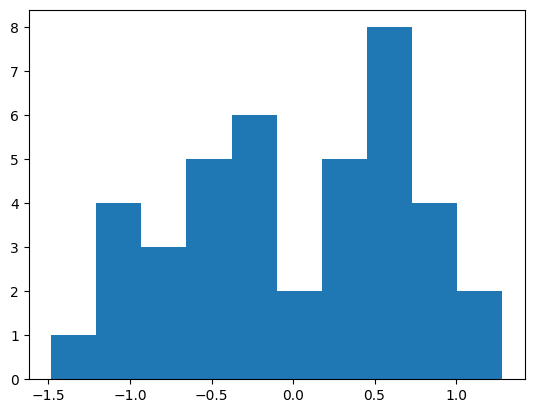

In [16]:
import matplotlib.pyplot as plt

plt.hist(residuos)
plt.show()

Para confirmar que el modelo se explica de forma correcta con valores lineales, utilizamos la prueba RESET de Ramsey. Atendemos al p-valor para analizar los contrastes del test de hipótesis asociado:

In [17]:
p_valor_reset = linear_reset(modelo).pvalue
print(f"P-valor del test RESET de Ramsey: {p_valor_reset}")

P-valor del test RESET de Ramsey: 0.9694338118335616


Posteriormente analizamos el test de Breusch-Pagan para comprobar si el modelo que hemos realizado es homocedástico con respecto a sus errores. Para realizar el contraste de hipótesis asociado a este test, la librería statsmodels cuenta con la función het_breuschpagan, que calcula p-valores asociados a dos estadísticos diferentes

In [ ]:
_, pv1_bp, _, pv2_bp = het_breuschpagan(residuos, X_train_unos)
print(f"P-valor del test de Breusch-Pagan: {pv1_bp} y {pv2_bp}")

P-valor del test de Breusch-Pagan: 0.24438378880161352 y 0.2592819128985973


Utilizamos el test de Shapiro-Wilk para estudiar la normalidad de los residuos

In [18]:
_,p_valor_shapiro = shapiro(residuos)
print(f"P-valor Shapiro-Wilk: {p_valor_shapiro}")

P-valor Shapiro-Wilk: 0.33472437284803047


Finalmente, con el estadístico de Durbin-Watson evaluamos si los residuos son independientes. El estadístico va de 0 hasta 4, donde un valor cercano a 2 indica la ausencia de autocorrelación

In [19]:
estadistico_durbin_watson = durbin_watson(residuos)
print(f"Estadístico de Durbin-Watson: {estadistico_durbin_watson}")

Estadístico de Durbin-Watson: 2.538054897541931


Una vez que hemos visto que el modelo cumple con los supuestos, vamos a aplicar las predicciones y evaluar su rendimiento. Usamos los conjuntos de test para predecir los resultados del modelo (previamente añadimos la columna de unos también a nuestro X_test)

In [20]:
X_test_unos = sm.add_constant(X_test)

In [21]:
predicciones = modelo.predict(X_test_unos)

Imprimimos las 10 predicciones y los 10 valores reales para comprobar en primera instancia como funciona el modelo:

In [22]:
for i in range(10):

  print('Prediccion: '+str(list(predicciones)[i]))
  print('Valor real: '+str(list(y_test)[i][0]))
  print('')

Prediccion: 71.6566143787825
Valor real: 70.43

Prediccion: 70.33393260249164
Valor real: 70.08

Prediccion: 71.88590447916252
Valor real: 72.48

Prediccion: 70.96869346456478
Valor real: 71.64

Prediccion: 70.9449506630782
Valor real: 70.88

Prediccion: 72.46833150406023
Valor real: 72.13

Prediccion: 70.77176272903095
Valor real: 70.66

Prediccion: 71.10376224530751
Valor real: 70.93

Prediccion: 72.36942402984432
Valor real: 71.71

Prediccion: 70.81894931773267
Valor real: 70.29



Imprimimos los resultados de las mediciones del modelo

In [23]:
mae = mean_absolute_error(y_test, predicciones)

mse = mean_squared_error(y_test, predicciones)

r_cuadrado = r2_score(y_test, predicciones)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r_cuadrado}")

MAE: 0.46231295266007494
MSE: 0.32486650058760624
R^2: 0.46214244581117037
